In [7]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from ortools.linear_solver import pywraplp
import timeit
import random
import time

In [26]:
def model(packages,cargo):
    solver = pywraplp.Solver('Model2DR', pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)
    # importo dimensioni dei pacchi e del camion
    n=len(packages)

    w =[packages[i].getW() for i in range(n)]
    d =[packages[i].getD() for i in range(n)]
    h =[packages[i].getH() for i in range(n)]
    
    print(w)
    print(d)
    print(h)

    W =cargo.getW()
    D =solver.IntVar(0,solver.infinity(),"D")
    H =cargo.getH()
    
    Md=sum(d)
    Mw=W+min(w)
    Mz=sum(h)

    # definisco le variabili
    l =[[solver.BoolVar("l%d%d" % (i,j)) for i in range(n)] for j in range(n)]
    b =[[solver.BoolVar("b%d%d" % (i,j)) for i in range(n)] for j in range(n)]
    t =[[solver.BoolVar("t%d%d" % (i,j)) for i in range(n)] for j in range(n)]
    r =[solver.BoolVar("r%d" % (i)) for i in range(n)]

    x =[solver.IntVar(0,solver.infinity(),"x%d" % i) for i in range(n)]
    y =[solver.IntVar(0,solver.infinity(),"y%d" % i) for i in range(n)]
    z =[solver.IntVar(0,solver.infinity(),"z%d" % i) for i in range(n)]



    # definisco i constraints
    for i in range(n):
        for j in range(n):
            if(i < j):
                solver.Add(l[i][j] + l[j][i] + b[i][j] + b[j][i] + t[i][j] + t[j][i] >= 1)
            if(i != j):
                solver.Add(x[i] - x[j] + Mw * l[i][j] <= Mw - w[i]*(1-r[i]) - d[i]*r[i])
                solver.Add(y[i] - y[j] + Md * b[i][j] <= Md - d[i]*(1-r[i]) - w[i]*r[i])
                solver.Add(z[i] - z[j] + Mz * t[i][j] <= Mz - h[i])
                
        solver.Add(x[i] + w[i]*(1-r[i]) + d[i]*r[i] <= W)
        solver.Add(y[i] + d[i]*(1-r[i]) + w[i]*r[i] <= D)
        solver.Add(z[i] + h[i] <= H)
        #solver.Add(solver.Sum([t[i][j] for j in range(n) if i!=j])*Mz >= z[i])

    #funzione obiettivo
    objective = solver.Objective()
    objective.SetCoefficient(D,1)
    objective.SetMinimization()
    
    #soluzione
    solver.SetTimeLimit(20000)
    solver.Solve()

    for i in range(n):
        for j in range(n):
            print z[i].solution_value() ,- z[j].solution_value() , Mz * t[i][j].solution_value(), Mz, - z[i].solution_value()
    #lista soluzioni
    s = []
    for i in range(n):
        s.append([x[i].solution_value(), y[i].solution_value(), i, r[i].solution_value(),z[i].solution_value()])
    return s

In [27]:
def plotSolution(solution, camion, packages):
    boxes = []

    width = [p.dimensioni[0] for p in packages]
    depth = [p.dimensioni[1] for p in packages]
    print width
    #bin
    container = Rectangle((0,0), camion.dimensioni[1], camion.dimensioni[0], facecolor='white')
    boxes.append(container)

    #items
    for a in solution:
        w =width[a[2]] if a[3] == 0 else depth[a[2]]
        #print width[a[2]],w,a[3]
        d = depth[a[2]] if a[3] == 0 else width[a[2]]
        box = Rectangle((a[1],a[0]), d, w, facecolor='r')
        boxes.append(box)
    #plot
    facecolors = [b.get_facecolor() for b in boxes]

    collection = PatchCollection(boxes, facecolor=facecolors, alpha=0.4, edgecolor='black', linewidths=2)

    ax = plt.gca(xlabel='depth',ylabel='width')
    ax.add_collection(collection)
    ax.autoscale_view()
    ax.axis('equal')
    plt.draw_if_interactive()

In [28]:
def main():
    packages =[]
    for i in range(0,4):
        w=120
        d=80
        h=100
        packages.append(box([w,d,h]))
    camion =cargo([250,1350,270])
    t=time.time()
    s =model(packages,camion)
    print s
    plotSolution(s,camion,packages)
    t=time.time()-t
    print(t)

In [29]:
class box:
    def __init__(self,dim):
        self.dimensioni=dim

    def getW(self):
        return self.dimensioni[0]

    def getD(self):
        return self.dimensioni[1]
    
    def getH(self):
        return self.dimensioni[2]

In [30]:
class cargo:
    def __init__(self,dim):
        self.dimensioni=dim

    def getW(self):
        return self.dimensioni[0]

    def getD(self):
        return self.dimensioni[1]
    
    def getH(self):
        return self.dimensioni[2]


[120, 120, 120, 120]
[80, 80, 80, 80]
[100, 100, 100, 100]
0.0 -0.0 0.0 400 -0.0
0.0 -0.0 0.0 400 -0.0
0.0 -170.0 0.0 400 -0.0
0.0 -100.0 400.0 400 -0.0
0.0 -0.0 0.0 400 -0.0
0.0 -0.0 0.0 400 -0.0
0.0 -170.0 400.0 400 -0.0
0.0 -100.0 400.0 400 -0.0
170.0 -0.0 0.0 400 -170.0
170.0 -0.0 0.0 400 -170.0
170.0 -170.0 0.0 400 -170.0
170.0 -100.0 0.0 400 -170.0
100.0 -0.0 0.0 400 -100.0
100.0 -0.0 0.0 400 -100.0
100.0 -170.0 0.0 400 -100.0
100.0 -100.0 0.0 400 -100.0
[[0.0, 0.0, 0, 0.0, 0.0], [120.0, 0.0, 1, 0.0, 0.0], [120.0, 0.0, 2, 0.0, 170.0], [0.0, 0.0, 3, 0.0, 100.0]]
[120, 120, 120, 120]
0.243582963943


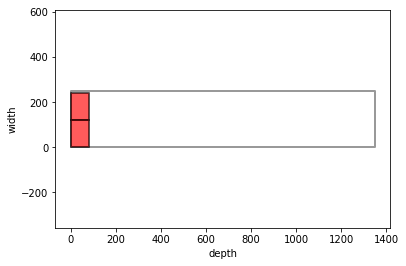

In [31]:
main()